# Manifesto map

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize

from text_functions import read_index, read_text_files
from text_functions import tokenize

from clustering_functions import calculate_simularity_matrix, pca_reduction

from plot_functions import plot_matrix, plot_dendogram, plot_scatter

import pprint

In [2]:
PATH = 'data/'              #path for data
INDEX_FILE = 'index.csv'    #location of index file 
ENCODING = 'utf-8-sig'      #Encoding of files
METHOD = 'Tfidf'            #'Tfidf' for Term Frequency - Inverse Document Frequency 
                            # or 'Count' for naive methods
MAX_DF=0.8                  #default 1.0
MIN_DF=2                    #default 1
STEM = True                 #stem words?
PCA_COMPONENTS = 2          #number of PCA components to keep (only two are plotted)
OFFSET = 0                  #Offset for annotations on scatter plot
ANNOTATE_PLOT = False       #Annotate scatter plot
VERBOSE = False             #Add more information?

In [3]:
index_filename = PATH + INDEX_FILE
index_dict = read_index(index_filename, ENCODING)
if VERBOSE:
    pprint.pp(index_dict)
corpus = read_text_files(index_dict, ENCODING, PATH)

In [4]:
if METHOD == 'Tfidf':
    if STEM:
        vectorizer = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF, tokenizer=tokenize)
    else:
        vectorizer = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF)
elif METHOD == 'count':
    if STEM:
        vectorizer = CountVectorizer(tokenizer=tokenize)
    else:
        vectorizer = CountVectorizer()
else:
    raise Exception('Unknown methods')

# Fit the vectorizer to the documents and transform the documents into a document-term matrix
X = vectorizer.fit_transform(corpus)

# Get the feature names (tokens)
feature_names = vectorizer.get_feature_names_out()

In [5]:
print(f'There are {len(feature_names)} features')

In [6]:
normalised_matrix = normalize(X, norm='l2', axis=1)
simularity_matrix = calculate_simularity_matrix(normalised_matrix)

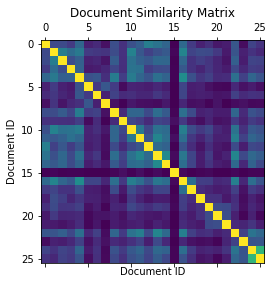

In [7]:
plot_matrix(simularity_matrix)

In [8]:
x, y = pca_reduction(simularity_matrix, PCA_COMPONENTS)

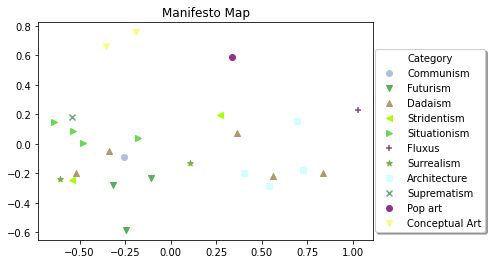

In [9]:
plot_scatter(index_dict, x, y, OFFSET, annotate=ANNOTATE_PLOT)

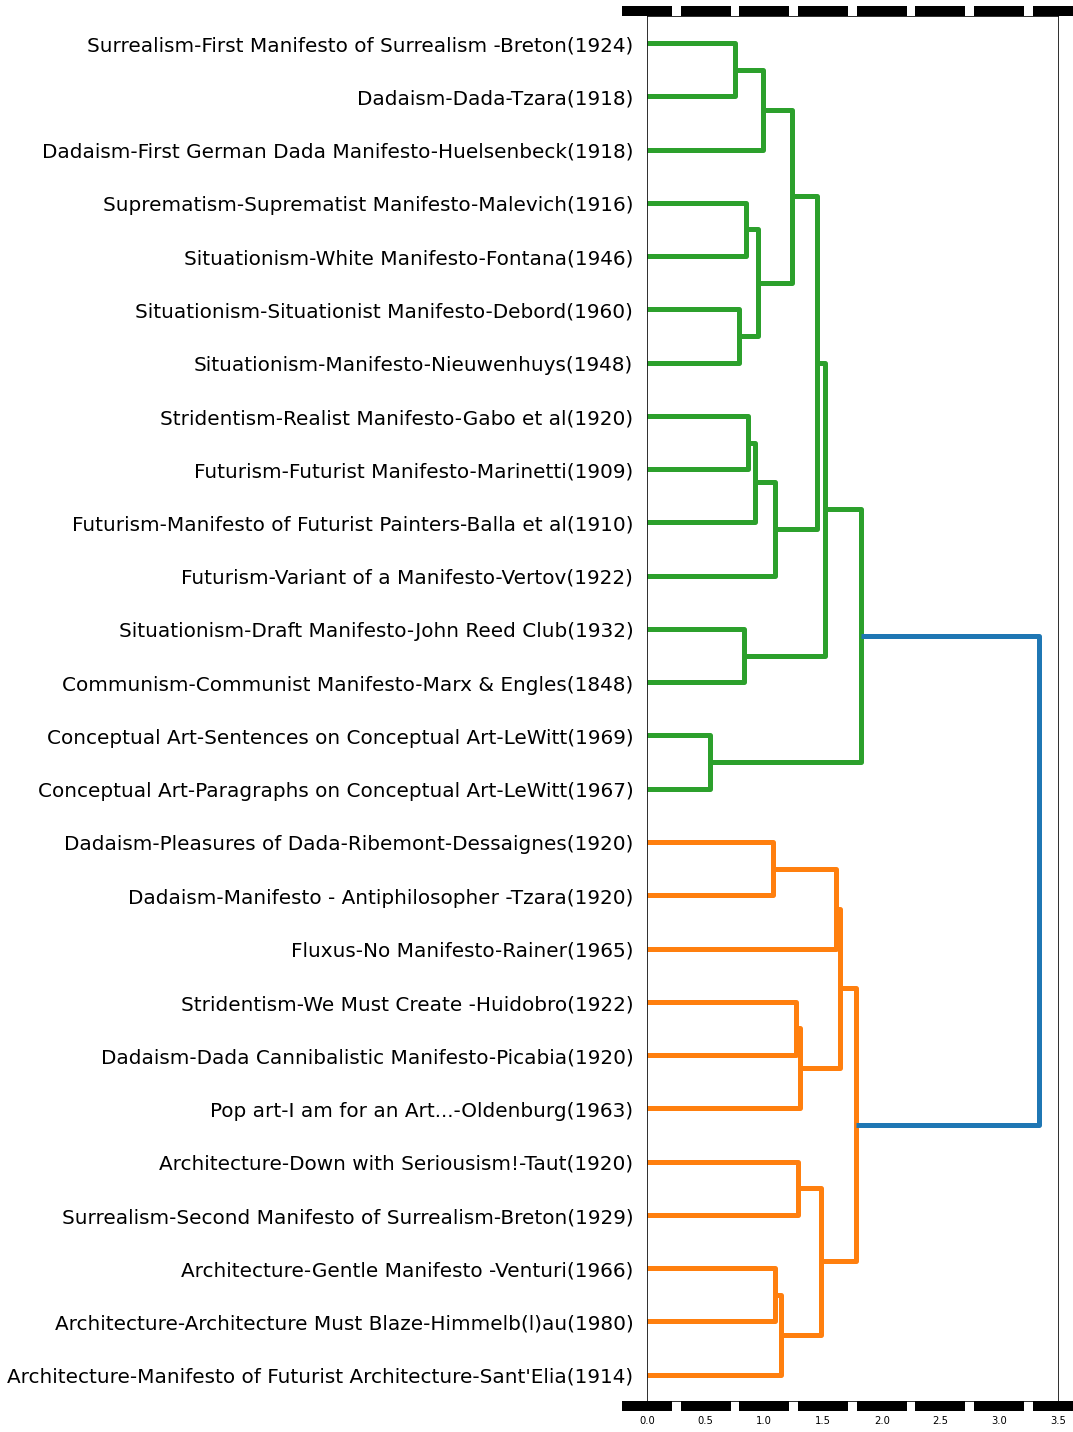

In [10]:
plot_dendogram(simularity_matrix, index_dict)